## Notebook to simplify EEZ geometries and gadm

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas
import os
import json
# from pandarallel import pandarallel
# import topojson as tp
from zipfile import ZipFile

### Simplification EEZ

In [68]:
eez = gpd.read_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_dissolved/eez_dissolved.shp')
len(eez)

202

In [69]:
# Fix topological errors
!mapshaper-xl -i snap /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_dissolved/eez_dissolved.shp -clean gap-fill-area=30km2 -o format=shapefile /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.shp force

Allocating 8 GB of heap memory
[i] Snapped 24292 points
[clean] Removed 216,765 / 218,558 slivers using 30+ sqkm variable threshold
[clean] Retained 202 of 202 features
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.shp
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.shx
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.dbf
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.prj


In [70]:
eez = gpd.read_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_corrected/eez_corrected.shp')
len(eez)

202

In [71]:
%%time
sum(eez.is_valid) # all valid

CPU times: user 3.81 s, sys: 281 ms, total: 4.09 s
Wall time: 4.14 s


202

In [72]:
eez.head()

,GID_0,Shape_Leng,Shape_Area,AREA_KM,geometry
0,ABW,8.600131,2.504937,29970.299588,"POLYGON ((-68.87017 15.24185, -68.88133 15.200..."
1,AGO,49.857334,41.178688,495859.762742,"MULTIPOLYGON (((11.78965 -17.27214, 11.78958 -..."
2,AIA,12.561376,7.784427,90157.964205,"POLYGON ((-60.73667 20.92203, -60.76437 20.877..."
3,ALB,10.366878,1.300663,12165.548773,"POLYGON ((20.00835 39.69182, 20.00810 39.69187..."
4,ARE,39.797245,5.174869,57838.146798,"MULTIPOLYGON (((57.12739 25.11714, 57.10390 25..."


In [73]:
# Break the shp into 10 json files
!mapshaper-xl 16gb -i ./../../HE_Data/NRC/NRC_Marine/eez_corrected/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/21)+1" \
    -split group \
    -o EEZ_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote EEZ_test/1.json
[o] Wrote EEZ_test/2.json
[o] Wrote EEZ_test/3.json
[o] Wrote EEZ_test/4.json
[o] Wrote EEZ_test/5.json
[o] Wrote EEZ_test/6.json
[o] Wrote EEZ_test/7.json
[o] Wrote EEZ_test/8.json
[o] Wrote EEZ_test/9.json
[o] Wrote EEZ_test/10.json


In [74]:
## First test with all parameters
!mapshaper-xl 16gb -i ./EEZ_test/*.json snap \
    -simplify 10% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
    -filter-slivers min-area=10000m2 remove-empty \
    -clean rewind \
    -o EEZ_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 180 intersections
[filter-islands] Removed 0 islands
[filter-slivers] Removed 0 slivers using 0.01+ sqkm variable threshold
[clean] Retained 21 of 21 features
[o] Wrote EEZ_test/1.json
[i] Snapped 0 points
[simplify] Repaired 374 intersections; 2 intersections could not be repaired
[filter-islands] Removed 0 islands
[filter-slivers] Removed 1 sliver using 0.01+ sqkm variable threshold
[clean] Removed 2 / 169 slivers using 21+ sqkm variable threshold
[clean] Retained 13 of 13 features
[o] Wrote EEZ_test/10.json
[i] Snapped 0 points
[simplify] Repaired 470 intersections
[filter-islands] Removed 0 islands
[filter-slivers] Removed 2 slivers using 0.01+ sqkm variable threshold
[clean] Retained 21 of 21 features
[o] Wrote EEZ_test/2.json
[i] Snapped 0 points
[simplify] Repaired 78 intersections; 1 intersection could not be repaired
[filter-islands] Removed 0 islands
[filter-slivers] Removed 0 slivers using 0.01+ sqkm va

In [ ]:
# ### Final test: Only simplify (retains all geometries).
# !mapshaper-xl 16gb -i ./EEZ_test/*.json snap \
#     -simplify 10% weighting=0.3 planar keep-shapes \
#     -o EEZ_test/ format=geojson force ndjson

In [75]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./EEZ_test/*.json combine-files -merge-layers -info -o EEZ_test/simp-eez.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
--------------------------------
Type:     polygon
Records:  202
Bounds:   -180,-85.5625,180,86.994
CRS:      +proj=longlat +datum=WGS84
Source:   ./EEZ_test/1.json

Attribute data
------------+-------------------
 Field      | First value
------------+-------------------
 AREA_KM    | 29970.2995877
 GID_0      | 'ABW'
 group      |     1
 Shape_Area |     2.50493679501
 Shape_Leng |     8.60013133744
------------+-------------------

[o] Wrote EEZ_test/simp-eez.shp
[o] Wrote EEZ_test/simp-eez.shx
[o] Wrote EEZ_test/simp-eez.dbf
[o] Wrote EEZ_test/simp-eez.prj


In [76]:
sim = gpd.read_file('EEZ_test/simp-eez.shp') # len 202, retains all geometries
len(sim)

202

In [77]:
%%time
sum(sim.is_valid)

CPU times: user 469 ms, sys: 19.7 ms, total: 489 ms
Wall time: 495 ms


202

<AxesSubplot:>

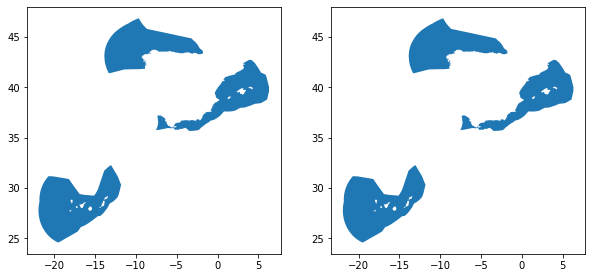

In [78]:
# check if new geometries in corrected database are the same as the simplified
n= 'ESP'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
eez[eez['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

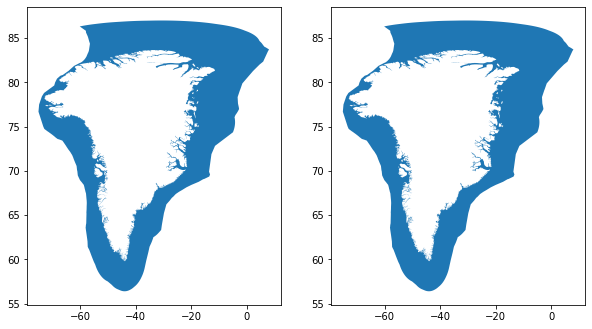

In [79]:
# check if new geometries in corrected database are the same as the simplified
n= 'GRL'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
eez[eez['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

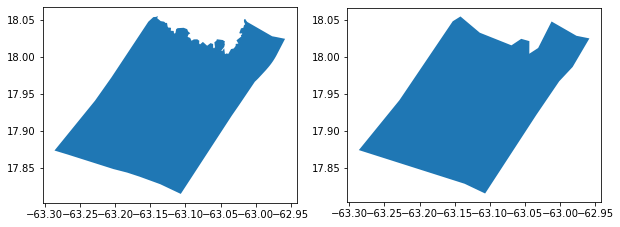

In [80]:
# check if new geometries in corrected database are the same as the simplified
n= 'SXM'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
eez[eez['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

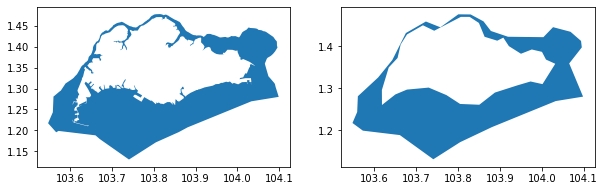

In [81]:
# check if new geometries in corrected database are the same as the simplified
n= 'SGP'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
eez[eez['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

In [82]:
eez.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
# Save file in local
sim.to_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Marine/eez_simplified/eez_simplified.shp', driver= 'ESRI Shapefile')

-----------------------
## Simplification gadm

In [84]:
zipfile = '/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_original'
unzipfile = ZipFile(f'{zipfile}.zip').extractall(zipfile)
gadm = gpd.read_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_original/gadm36_level0_original.shp')
len(gadm)

255

In [87]:
%%time
# Fix topological errors
!mapshaper-xl -i snap /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_original/gadm36_level0_original.shp -clean gap-fill-area=30km2 -o format=shapefile /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.shp force

Allocating 8 GB of heap memory
[i] Snapped 76 points
[clean] Removed 1,924 / 1,927 slivers using 30+ sqkm variable threshold
[clean] Retained 255 of 255 features
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.shp
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.shx
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.dbf
[o] Wrote /Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.prj
CPU times: user 2.1 s, sys: 632 ms, total: 2.73 s
Wall time: 2min 39s


In [88]:
%%time
gadm = gpd.read_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_corrected/gadm36_level0_corrected.shp')
len(gadm)

CPU times: user 7.03 s, sys: 1.33 s, total: 8.36 s
Wall time: 8.65 s


255

In [89]:
gadm.head()

,GID_0,NAME_0,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,geometry
0,ABW,Aruba,1.819384e+02,1,0.963634,0.015131,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,6.438575e+05,2,57.103371,62.749594,"POLYGON ((68.53852 31.75457, 68.57610 31.75160..."
2,AGO,Angola,1.247422e+06,3,73.796528,103.818655,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,8.330331e+01,4,1.318321,0.007116,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Ã land,1.506261e+03,5,42.232199,0.243769,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


In [90]:
gadm2 = gadm[['GID_0', 'geometry']]
gadm2.head()

,GID_0,geometry
0,ABW,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,"POLYGON ((68.53852 31.75457, 68.57610 31.75160..."
2,AGO,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


In [91]:
wd = '/Users/sofia/Documents/Repos/he-scratchfolder'

In [94]:
%%time
gadm2.to_file(f'{wd}/gadm_test/gadm.shp', driver='ESRI Shapefile')

CPU times: user 3min 43s, sys: 3.65 s, total: 3min 47s
Wall time: 3min 48s


In [95]:
# Break the shp into 10 json files
!mapshaper-xl 16gb -i gadm_test/*.shp no-topology combine-files \
    -merge-layers \
    -each "group = Math.trunc(this.id/26)+1" \
    -split group \
    -o gadm_test/ format=geojson precision=0.0001 force ndjson

Allocating 16 GB of heap memory
[merge-layers] Use the target= option to specify multiple layers for merging
[o] Wrote gadm_test/1.json
[o] Wrote gadm_test/2.json
[o] Wrote gadm_test/3.json
[o] Wrote gadm_test/4.json
[o] Wrote gadm_test/5.json
[o] Wrote gadm_test/6.json
[o] Wrote gadm_test/7.json
[o] Wrote gadm_test/8.json
[o] Wrote gadm_test/9.json
[o] Wrote gadm_test/10.json


In [96]:
## First test with all parameters
!mapshaper-xl 16gb -i ./gadm_test/*.json snap \
    -simplify 15% weighting=0.3 planar keep-shapes \
    -filter-islands min-vertices=3 min-area=10000m2 remove-empty \
    -filter-slivers min-area=10000m2 remove-empty \
    -clean rewind \
    -o gadm_test/ format=geojson force ndjson

Allocating 16 GB of heap memory
[i] Snapped 0 points
[simplify] Repaired 118 intersections; 1 intersection could not be repaired
[filter-islands] Removed 7,922 islands
[filter-slivers] Removed 120 slivers using 0.01+ sqkm variable threshold
[clean] Removed 2 / 4 slivers using 0.36+ sqkm variable threshold
[clean] Retained 26 of 26 features
[o] Wrote gadm_test/1.json
[i] Snapped 0 points
[simplify] Repaired 46 intersections; 1 intersection could not be repaired
[filter-islands] Removed 4,739 islands
[filter-slivers] Removed 13 slivers using 0.01+ sqkm variable threshold
[clean] Removed 1 / 3 sliver using 0.17+ sqkm variable threshold
[clean] Retained 21 of 21 features
[o] Wrote gadm_test/10.json
[i] Snapped 0 points
[simplify] Repaired 59 intersections; 1 intersection could not be repaired
[filter-islands] Removed 15,959 islands
[filter-slivers] Removed 105 slivers using 0.01+ sqkm variable threshold
[clean] Removed 1 / 3 sliver using 0.11+ sqkm variable threshold
[clean] Retained 26 of

In [ ]:
# ### Final test: Only simplify (retains all geometries).
# !mapshaper-xl 16gb -i ./EEZ_test/*.json snap \
#     -simplify 10% weighting=0.3 planar keep-shapes \
#     -o EEZ_test/ format=geojson force ndjson

In [97]:
# Combine all json files in a shp. 
!mapshaper-xl 16gb -i ./gadm_test/*.json combine-files -merge-layers -info -o gadm_test/simp-gadm.shp

Allocating 16 GB of heap memory
[info] 
Layer:    [unnamed layer]
-------------------------
Type:     polygon
Records:  255
Bounds:   -180,-90,180,83.6583
CRS:      +proj=longlat +datum=WGS84
Source:   ./gadm_test/1.json

Attribute data
-------+-------------
 Field | First value
-------+-------------
 GID_0 | 'ABW'
 group | 1
-------+-------------

[o] Wrote gadm_test/simp-gadm.shp
[o] Wrote gadm_test/simp-gadm.shx
[o] Wrote gadm_test/simp-gadm.dbf
[o] Wrote gadm_test/simp-gadm.prj


In [98]:
sim = gpd.read_file('gadm_test/simp-gadm.shp') # len 201 ### retains all geometries
len(sim)

255

In [99]:
%%time
sum(sim.is_valid)

CPU times: user 1min 56s, sys: 947 ms, total: 1min 57s
Wall time: 2min


255

In [100]:
sim.head()

,GID_0,group,geometry
0,ABW,1,"POLYGON ((-69.97820 12.46990, -69.97790 12.472..."
1,AFG,1,"POLYGON ((68.45660 31.74070, 68.44530 31.74250..."
2,AGO,1,"MULTIPOLYGON (((11.83710 -17.23690, 11.82860 -..."
3,AIA,1,"MULTIPOLYGON (((-63.06850 18.23680, -63.05680 ..."
4,ALA,1,"MULTIPOLYGON (((20.17340 60.28730, 20.18280 60..."


In [101]:
sim= sim.drop(columns='group')
sim.head()

,GID_0,geometry
0,ABW,"POLYGON ((-69.97820 12.46990, -69.97790 12.472..."
1,AFG,"POLYGON ((68.45660 31.74070, 68.44530 31.74250..."
2,AGO,"MULTIPOLYGON (((11.83710 -17.23690, 11.82860 -..."
3,AIA,"MULTIPOLYGON (((-63.06850 18.23680, -63.05680 ..."
4,ALA,"MULTIPOLYGON (((20.17340 60.28730, 20.18280 60..."


In [102]:
gadm.head()

,GID_0,NAME_0,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,geometry
0,ABW,Aruba,1.819384e+02,1,0.963634,0.015131,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,Afghanistan,6.438575e+05,2,57.103371,62.749594,"POLYGON ((68.53852 31.75457, 68.57610 31.75160..."
2,AGO,Angola,1.247422e+06,3,73.796528,103.818655,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,Anguilla,8.330331e+01,4,1.318321,0.007116,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,Ã land,1.506261e+03,5,42.232199,0.243769,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


<AxesSubplot:>

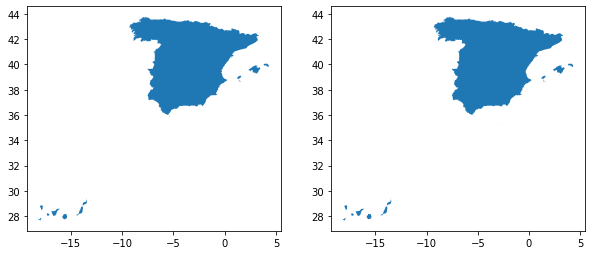

In [103]:
# check if new geometries in corrected database are the same as the simplified
n= 'ESP'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gadm[gadm['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

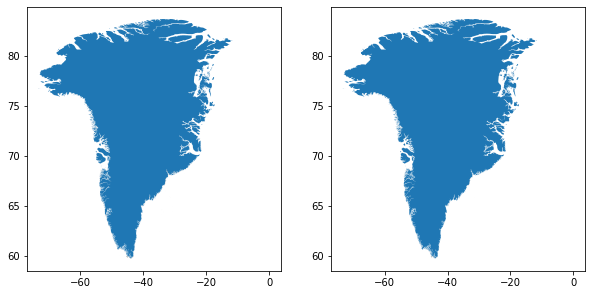

In [104]:
# check if new geometries in corrected database are the same as the simplified
n= 'GRL'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gadm[gadm['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

In [105]:
gadm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [106]:
sim.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

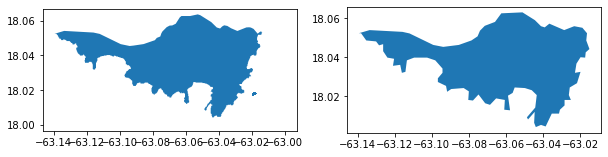

In [107]:
# check if new geometries in corrected database are the same as the simplified
n= 'SXM'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gadm[gadm['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

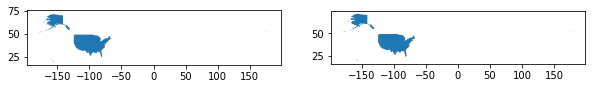

In [108]:
# check if new geometries in corrected database are the same as the simplified
n= 'USA'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
gadm[gadm['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

In [109]:
import pandas as pd
sim = pd.merge(sim, gadm,  how='left', left_on=['GID_0'], right_on = ['GID_0'])
sim.head()

,GID_0,geometry_x,NAME_0,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area,geometry_y
0,ABW,"POLYGON ((-69.97820 12.46990, -69.97790 12.472...",Aruba,1.819384e+02,1,0.963634,0.015131,"POLYGON ((-69.97820 12.46986, -69.97847 12.469..."
1,AFG,"POLYGON ((68.45660 31.74070, 68.44530 31.74250...",Afghanistan,6.438575e+05,2,57.103371,62.749594,"POLYGON ((68.53852 31.75457, 68.57610 31.75160..."
2,AGO,"MULTIPOLYGON (((11.83710 -17.23690, 11.82860 -...",Angola,1.247422e+06,3,73.796528,103.818655,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -..."
3,AIA,"MULTIPOLYGON (((-63.06850 18.23680, -63.05680 ...",Anguilla,8.330331e+01,4,1.318321,0.007116,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ..."
4,ALA,"MULTIPOLYGON (((20.17340 60.28730, 20.18280 60...",Ã land,1.506261e+03,5,42.232199,0.243769,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59..."


In [111]:
sim = sim.drop(columns={'geometry_y'}).rename(columns={'geometry_x':'geometry'})
sim.head()

,GID_0,geometry,NAME_0,AREA_KM2,MOL_ID,Shape_Leng,Shape_Area
0,ABW,"POLYGON ((-69.97820 12.46990, -69.97790 12.472...",Aruba,1.819384e+02,1,0.963634,0.015131
1,AFG,"POLYGON ((68.45660 31.74070, 68.44530 31.74250...",Afghanistan,6.438575e+05,2,57.103371,62.749594
2,AGO,"MULTIPOLYGON (((11.83710 -17.23690, 11.82860 -...",Angola,1.247422e+06,3,73.796528,103.818655
3,AIA,"MULTIPOLYGON (((-63.06850 18.23680, -63.05680 ...",Anguilla,8.330331e+01,4,1.318321,0.007116
4,ALA,"MULTIPOLYGON (((20.17340 60.28730, 20.18280 60...",Ã land,1.506261e+03,5,42.232199,0.243769


In [112]:
geom = gpd.read_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/LA_GADM_clean_dateline/LA_GADM_clean_dateline.shp')
len(geom)

252

<AxesSubplot:>

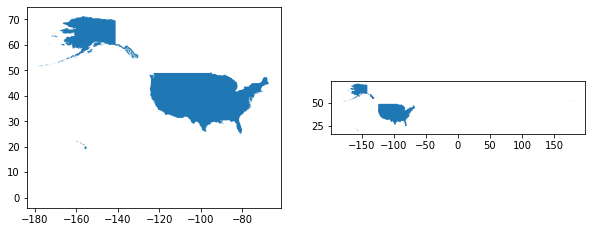

In [113]:
# check if new geometries in corrected database are the same as the simplified
n= 'USA'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

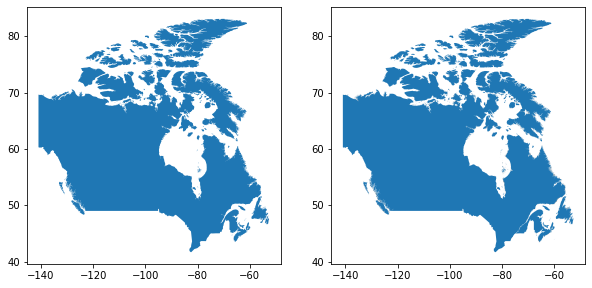

In [114]:
# check if new geometries in corrected database are the same as the simplified
n= 'CAN'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

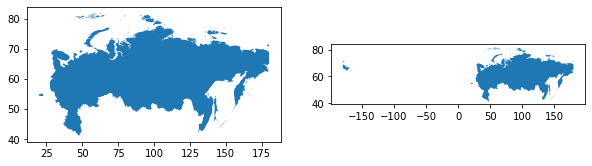

In [115]:
# check if new geometries in corrected database are the same as the simplified
n= 'RUS'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim[sim['GID_0']==n].geometry.plot(ax = ax2)

#### Some of the gadm36 geometries (USA, RUSIA, CANADA) gave errors on the map in the AOIS so they were changed to use the ones in the NRC (which gave no problems). Let's do the same here

In [116]:
sim.index[sim.GID_0=='USA'][0]

26

In [117]:
sim.index[sim.GID_0=='RUS'][0]

210

In [118]:
sim.index[sim.GID_0=='CAN'][0]

60

In [119]:
geom.index[geom.GID_0=='USA'][0]

248

In [120]:
geom.index[geom.GID_0=='RUS'][0]

249

In [121]:
geom.index[geom.GID_0=='CAN'][0]

39

In [122]:
sim2 = sim.copy()

In [123]:
sim2.geometry.loc[26]=geom.geometry.loc[248]
sim2.geometry.loc[210]=geom.geometry.loc[249]
sim2.geometry.loc[60]=geom.geometry.loc[39]

<AxesSubplot:>

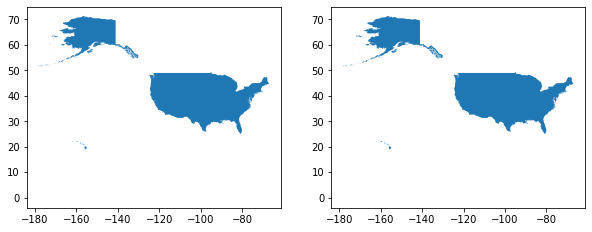

In [124]:
# check if new geometries in corrected database are the same as the simplified
n= 'USA'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim2[sim2['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

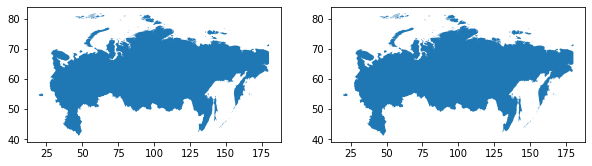

In [125]:
# check if new geometries in corrected database are the same as the simplified
n= 'RUS'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim2[sim2['GID_0']==n].geometry.plot(ax = ax2)

<AxesSubplot:>

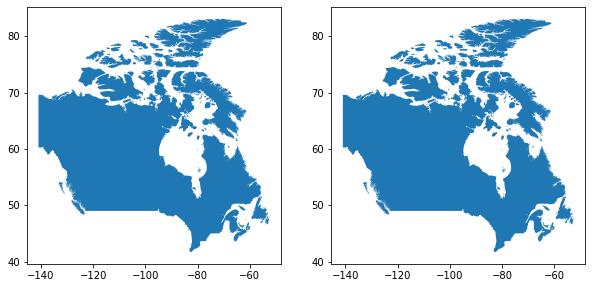

In [126]:
# check if new geometries in corrected database are the same as the simplified
n= 'CAN'
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
geom[geom['GID_0']==n].geometry.plot(ax = ax1) 
sim2[sim2['GID_0']==n].geometry.plot(ax = ax2)

In [127]:
# Save file in local
sim2.to_file('/Users/sofia/Documents/HE_Data/NRC/NRC_Terrestrial/gadm36_level0_simplified/gadm36_level0_simplified', driver= 'ESRI Shapefile')